In [1]:
import numpy as np
from sympy import Symbol
import roboticstoolbox as rtb
from scipy.optimize import fsolve
from delta_robot import DeltaRobot
import matplotlib.pyplot as plt

# importing plotly for plotting
import plotly.graph_objects as go

# Path generation using De- Casteljau's algorithm

In [9]:


def lerp(P1, P2, t):
    return P1*(1- t)+ P2*(t)

def generate_spline(start_point, cp_1, cp_2, end_point):
    # start_point, cp_1, cp_2, end_point are all 3D points
    # return a list of 3D points
    spline = []
    for t in np.linspace(0, 1, 100):
        P1 = lerp(start_point, cp_1, t)
        P2 = lerp(cp_1, cp_2, t)
        P3 = lerp(cp_2, end_point, t)
        P4 = lerp(P1, P2, t)
        P5 = lerp(P2, P3, t)
        P6 = lerp(P4, P5, t)
        spline.append(P6)
    return spline


In [1]:
from essentials import *
from delta_robot import DeltaRobot
import matplotlib.pyplot as plt
import plotly.graph_objects as go

r = 200
h = 300
s = 140
k = 500
Zt = 0
robot = DeltaRobot(r, h, s, k, Zt)


object_points = [
    [0, -50, -500],
    [50, 50, -500],
    [-100, 20, -500],
    [100, -10, -500],
]

green_box = [0, -200, -500]
home_pos = robot.calculate_fwd_kinematics(0, 0, 0)

planner = PNPTestPath(robot, object_points, green_box)
commands, spline = planner.plan_path()

x, y, z = map(list, zip(*spline))

theta_space = []
for i in range(len(spline)):
    theta_space.append(robot.calculate_inv_kinematics(spline[i][0], spline[i][1], spline[i][2]))

# PLot sample points in the spline
sample_spl_points = []

for i in np.arange(0, 900, 10):
    sample_spl_points.append(spline[i])

x_s, y_s, z_s = map(list, zip(*sample_spl_points))

x_o, y_o, z_o = map(list, zip(*object_points))

# Plot P in 3D using plotly
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='lines', name = 'Path')])
# fig.add_trace(go.Scatter3d(x=x_s, y=y_s, z=z_s, mode='markers', marker=dict(size=2, color='red')))
fig.add_trace(go.Scatter3d(x=x_o, y=y_o, z=z_o, mode='markers', marker=dict(size=5, color='green'), name = 'Objects'))
fig.add_trace(go.Scatter3d(x=[green_box[0]], y=[green_box[1]], z=[green_box[2]], mode='markers', marker=dict(size=5, color='red'), name = 'Target Location'))
fig.add_trace(go.Scatter3d(x=[home_pos[0]], y=[home_pos[1]], z=[home_pos[2]], mode='markers', marker=dict(size=5, color='black'), name = 'Home Position'))

fig.update_layout(legend=dict(
    orientation = 'h',
    yanchor="bottom",
    y=0,
    xanchor="right",
    x=0.6
))


# Svae figure to html
fig.write_html("path.html")
fig.show()

In [3]:
# commands is a list of [m1, m2, m3], we need to plot m1 vs time, m2 vs time, m3 vs time
time = np.arange(0, len(commands), 1)

m1 = []
m2 = []
m3 = []
for i in range(len(commands)):
    m1.append(commands[i][0])
    m2.append(commands[i][1])
    m3.append(commands[i][2])

# plot using plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=m1, name = '&#952;<sub>1<sub>'))
fig.add_trace(go.Scatter(x=time, y=m2, name = '&#952;<sub>2<sub>'))
fig.add_trace(go.Scatter(x=time, y=m3, name = '&#952;<sub>3<sub>'))
fig.update_layout(legend=dict(
    orientation = 'h',
    yanchor="bottom",
    y=0,
    xanchor="right",
    x=0.6
))
# Add label
fig.update_xaxes(title_text="Time")
fig.update_yaxes(title_text= 'Joint angle (&#952;)')

#Save as image
fig.write_image('trajectory.png')

fig.show()

In [1]:
import numpy as np
import plotly.graph_objects as go
from essentials import *

# Assuming DeltaRobot and calculate_fwd_kinematics are correctly defined and imported

r = 200
h = 300
s = 140
k = 500
Zt = 0
robot = DeltaRobot(r, h, s, k, Zt)

# Define the joint angle ranges (in degrees) for the delta robot
angle_resolution = 25  # Number of points per angle range

# Example angle ranges; adjust according to your robot's constraints
theta1_range = np.linspace(-40, 80, angle_resolution)  # Joint 1
theta2_range = np.linspace(-40, 80, angle_resolution)  # Joint 2
theta3_range = np.linspace(-40, 80, angle_resolution)  # Joint 3

reachable_points = []

# Iterate through each combination of joint angles
for theta1 in theta1_range:
    for theta2 in theta2_range:
        for theta3 in theta3_range:
            try:
                # Compute the forward kinematics for the current set of angles
                pos = robot.calculate_fwd_kinematics(theta1, theta2, theta3)

                # pos should be a tuple or list (x, y, z)
                reachable_points.append(pos)

            except:
                # If the point is not reachable (due to singularities, etc.), skip it
                continue

# Convert reachable points to a NumPy array for easy plotting
reachable_points = np.array(reachable_points)

# Create a scatter plot using Plotly with a professional blue color
fig = go.Figure(data=[go.Scatter3d(
    x=reachable_points[:, 0],
    y=reachable_points[:, 1],
    z=reachable_points[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color='royalblue',  # Using a professional blue color
        opacity=0.7
    )
)])

# Update layout for better visualization
fig.update_layout(scene=dict(
                    xaxis=dict(title='X Axis', titlefont=dict(size=10), showticklabels=False, visible=False),
                    yaxis=dict(title='Y Axis', titlefont=dict(size=10), showticklabels=False, visible=False),
                    zaxis=dict(title='Z Axis', titlefont=dict(size=10), showticklabels=False, visible=False)),
                 title="Delta Robot Workspace",
                 showlegend=False,
                 margin=dict(l=0, r=0, b=0, t=40))

# Define camera views for different snapshots
views = [
    dict(eye=dict(x=1.25, y=1.25, z=1.25)),  # Front-Right View
    dict(eye=dict(x=-1.25, y=1.25, z=1.25)), # Front-Left View
    dict(eye=dict(x=0, y=0, z=2.5)),         # Top View
    dict(eye=dict(x=2.5, y=0, z=0)),         # Side View
]

# Customize appearance for professional look
for i, view in enumerate(views):
    fig.update_layout(scene_camera=view)
    
    # Customize specific views, e.g., hiding axes for side views
    if i == 2:  # Top view
        fig.update_layout(scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)))
    elif i == 3:  # Side view
        fig.update_layout(scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)))

    fig.show()  # Display each view for interactive inspection
    
    # Save each view as a high-resolution PNG image
    fig.write_image(f"delta_robot_workspace_view_{i}.png", width=1920, height=1080, scale=3)
    # Save each view as a high-resolution vector SVG image
    # fig.write_image(f"delta_robot_workspace_view_{i}.svg", width=1920, height=1080, scale=3)


In [36]:
from scipy.spatial import ConvexHull

# Workspace limits
X_upper = 800
X_lower = -500
Y_upper = 250
Y_lower = -250
Z_upper = -180
Z_lower = -550

reachable_points = []

# Iterate through each combination of joint angles
for theta1 in theta1_range:
    for theta2 in theta2_range:
        for theta3 in theta3_range:
            try:
                # Compute the forward kinematics for the current set of angles
                pos = robot.calculate_fwd_kinematics(theta1, theta2, theta3)

                # pos should be a tuple or list (x, y, z)
                x, y, z = pos

                # Check if the point is within the defined workspace limits
                if (X_lower <= x <= X_upper) and (Y_lower <= y <= Y_upper) and (Z_lower <= z <= Z_upper):
                    reachable_points.append(pos)

            except:
                # If the point is not reachable (due to singularities, etc.), skip it
                continue

# Convert reachable points to a NumPy array
reachable_points = np.array(reachable_points)

# Find the convex hull of the reachable points to create a boundary surface
hull = ConvexHull(reachable_points)

# Create a 3D mesh plot using Plotly
fig = go.Figure(data=[go.Mesh3d(
    x=reachable_points[hull.vertices, 0],
    y=reachable_points[hull.vertices, 1],
    z=reachable_points[hull.vertices, 2],
    color='lightblue',
    opacity=1,
    alphahull=1
)])

# Update layout for better visualization
fig.update_layout(scene=dict(
                    xaxis_title='X Axis',
                    yaxis_title='Y Axis',
                    zaxis_title='Z Axis'),
                    title="Delta Robot Workspace Boundary Surface")

# Show the plot
fig.show()

IndexError: tuple index out of range

## Change in Joint Angles with respect to path parameter

In [25]:
# get theta1, theta2 and theta3 from theta_space(a nested list)
theta_1, theta_2, theta_3 = map(list, zip(*theta_space))


# PLotting theta_space vs t for each angles
t = np.linspace(0, 1, 100)

# Plot theta for corresponding sample spline points
t_s = [t[i] for i in np.arange(0, 100, 10)]
theta_1_s = [theta_1[i] for i in np.arange(0, 100, 10)]
theta_2_s = [theta_2[i] for i in np.arange(0, 100, 10)]
theta_3_s = [theta_3[i] for i in np.arange(0, 100, 10)]


fig = go.Figure()
fig.add_trace(go.Scatter( y = theta_1, x = t, name = 'J1'))
fig.add_trace(go.Scatter(y = theta_2, x = t, name = 'J2'))
fig.add_trace(go.Scatter(y = theta_3, x = t, name = 'J3'))

fig.add_trace(go.Scatter(y = theta_1_s, x = t_s, name = 'J1_sample', mode = 'markers'))
fig.add_trace(go.Scatter(y = theta_2_s, x = t_s, name = 'J2_sample', mode = 'markers'))
fig.add_trace(go.Scatter(y = theta_3_s, x = t_s, name = 'J3_sample', mode = 'markers'))

fig.update_layout(title = 'Theta vs parameter t', xaxis_title = 'Parameter t', yaxis_title = 'Angle')
fig.show()

In [17]:
np.arange(0, 100, 10)

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

In [2]:
import pandas as pd

In [7]:
coordinates = pd.read_csv('gcode.csv', header = None)

In [11]:
all_angles = [[-0.0, -0.0, -0.0, 1], [0.8482, 0.8566, 0.8398, 1], [1.656, 1.69, 1.6221, 1], [2.4222, 2.4992, 2.3452, 1], [3.1457, 3.2837, 3.0078, 1], [3.8253, 4.0425, 3.6085, 1], [4.46, 4.7746, 4.146, 1], [5.0485, 5.4791, 4.6193, 1], [5.5899, 6.1549, 5.0273, 1], [6.0832, 6.8009, 5.3694, 1], [6.5274, 7.416, 5.645, 1], [6.9219, 7.9989, 5.8539, 1], [7.2659, 8.5487, 5.996, 1], [7.559, 9.0642, 6.0716, 1], [7.8008, 9.5443, 6.0814, 1], [7.9913, 9.9881, 6.0261, 1], [8.1305, 10.3946, 5.907, 1], [8.2185, 10.7631, 5.7253, 1], [8.2559, 11.0927, 5.4828, 1], [8.2433, 11.383, 5.1814, 1], [8.1814, 11.6335, 4.8231, 1], [8.0713, 11.8438, 4.4103, 1], [7.9141, 12.0139, 3.9454, 1], [7.7112, 12.1437, 3.4309, 1], [7.4639, 12.2333, 2.8694, 1], [7.1737, 12.283, 2.2638, 1], [6.8424, 12.2933, 1.6166, 1], [6.4716, 12.2647, 0.9307, 1], [6.0631, 12.1979, 0.2087, 1], [5.6186, 12.0936, -0.5468, 1], [5.14, 11.9529, -1.3331, 1], [4.6292, 11.7766, -2.1478, 1], [4.0878, 11.5658, -2.9885, 1], [3.5177, 11.3216, -3.8527, 1], [2.9206, 11.0452, -4.7384, 1], [2.2982, 10.7378, -5.6434, 1], [1.6521, 10.4005, -6.5659, 1], [0.9839, 10.0346, -7.5038, 1], [0.2951, 9.6413, -8.4555, 1], [-0.4128, 9.2218, -9.4193, 1], [-1.1385, 8.7773, -10.3939, 1], [-1.8807, 8.309, -11.3777, 1], [-2.6381, 7.818, -12.3694, 1], [-3.4096, 7.3055, -13.3679, 1], [-4.1941, 6.7725, -14.3721, 1], [-4.9905, 6.22, -15.381, 1], [-5.7979, 5.6492, -16.3936, 1], [-6.6154, 5.0608, -17.4091, 1], [-7.4422, 4.4559, -18.4267, 1], [-8.2773, 3.8353, -19.4457, 1], [-9.1202, 3.1999, -20.4656, 1], [-9.9701, 2.5505, -21.4856, 1], [-10.8264, 1.8878, -22.5053, 1], [-11.6884, 1.2125, -23.5241, 1], [-12.5557, 0.5254, -24.5418, 1], [-13.4276, -0.1729, -25.5577, 1], [-14.3037, -0.8818, -26.5717, 1], [-15.1836, -1.6007, -27.5834, 1], [-16.0667, -2.329, -28.5924, 1], [-16.9528, -3.0662, -29.5986, 1], [-17.8413, -3.8118, -30.6016, 1], [-18.732, -4.5653, -31.6013, 1], [-19.6246, -5.3262, -32.5974, 1], [-20.5186, -6.0941, -33.5897, 1], [-21.4138, -6.8686, -34.5781, 1], [-22.3098, -7.6492, -35.5624, 1], [-23.2065, -8.4356, -36.5425, 1], [-24.1035, -9.2274, -37.5181, 1], [-25.0005, -10.0243, -38.4892, 1], [-25.8973, -10.8258, -39.4556, 1], [-26.7937, -11.6316, -40.4171, 1], [-27.6893, -12.4414, -41.3736, 1], [-28.5839, -13.2549, -42.3249, 1], [-29.4773, -14.0717, -43.271, 1], [-30.3693, -14.8916, -44.2116, 1], [-31.2594, -15.7142, -45.1465, 1], [-32.1476, -16.5391, -46.0757, 1], [-33.0335, -17.3662, -46.9989, 1], [-33.9168, -18.195, -47.9159, 1], [-34.7973, -19.0253, -48.8265, 1], [-35.6747, -19.8568, -49.7305, 1], [-36.5486, -20.6891, -50.6276, 1], [-37.4188, -21.5219, -51.5177, 1], [-38.2849, -22.3549, -52.4003, 1], [-39.1466, -23.1878, -53.2752, 1], [-40.0035, -24.0202, -54.1422, 1], [-40.8553, -24.8517, -55.0007, 1], [-41.7015, -25.6821, -55.8505, 1], [-42.5417, -26.5109, -56.6911, 1], [-43.3755, -27.3377, -57.5221, 1], [-44.2024, -28.1623, -58.3431, 1], [-45.0219, -28.984, -59.1535, 1], [-45.8335, -29.8027, -59.9527, 1], [-46.6367, -30.6177, -60.7401, 1], [-47.4308, -31.4286, -61.5152, 1], [-48.2153, -32.235, -62.2773, 1], [-48.9895, -33.0364, -63.0255, 1], [-49.7526, -33.8322, -63.7591, 1], [-50.5041, -34.6219, -64.4773, 1], [-51.2431, -35.405, -65.1791, 1], [-51.2431, -35.405, -65.1791, 1], [-50.509, -34.6478, -64.4798, 1], [-49.7716, -33.9352, -63.7684, 1], [-49.031, -33.2665, -63.0448, 1], [-48.2872, -32.6416, -62.3092, 1], [-47.5404, -32.0601, -61.5615, 1], [-46.7909, -31.5218, -60.802, 1], [-46.0391, -31.0266, -60.0309, 1], [-45.2853, -30.5744, -59.2487, 1], [-44.5301, -30.1651, -58.4555, 1], [-43.774, -29.7987, -57.652, 1], [-43.0177, -29.4753, -56.8386, 1], [-42.2619, -29.1949, -56.0159, 1], [-41.5072, -28.9576, -55.1844, 1], [-40.7545, -28.7634, -54.3448, 1], [-40.0045, -28.6125, -53.4979, 1], [-39.2582, -28.5049, -52.6442, 1], [-38.5165, -28.4408, -51.7847, 1], [-37.7802, -28.4201, -50.9202, 1], [-37.0504, -28.443, -50.0514, 1], [-36.328, -28.5095, -49.1792, 1], [-35.614, -28.6195, -48.3047, 1], [-34.9095, -28.773, -47.4287, 1], [-34.2156, -28.97, -46.5522, 1], [-33.5332, -29.2103, -45.6763, 1], [-32.8635, -29.4937, -44.802, 1], [-32.2076, -29.82, -43.9304, 1], [-31.5665, -30.1889, -43.0625, 1], [-30.9413, -30.6, -42.1995, 1], [-30.3332, -31.0529, -41.3426, 1], [-29.7431, -31.5471, -40.4929, 1], [-29.1723, -32.082, -39.6516, 1], [-28.6217, -32.657, -38.8199, 1], [-28.0923, -33.2713, -37.9991, 1], [-27.5853, -33.9242, -37.1903, 1], [-27.1016, -34.6149, -36.3947, 1], [-26.6421, -35.3424, -35.6137, 1], [-26.2079, -36.1057, -34.8484, 1], [-25.7997, -36.9038, -34.1, 1], [-25.4185, -37.7357, -33.3699, 1], [-25.0651, -38.6, -32.6591, 1], [-24.7402, -39.4957, -31.9688, 1], [-24.4446, -40.4216, -31.3003, 1], [-24.1789, -41.3762, -30.6547, 1], [-23.9438, -42.3584, -30.033, 1], [-23.7398, -43.3668, -29.4363, 1], [-23.5674, -44.4, -28.8657, 1], [-23.4271, -45.4568, -28.3221, 1], [-23.3191, -46.5356, -27.8064, 1], [-23.2439, -47.6353, -27.3196, 1], [-23.2016, -48.7543, -26.8624, 1], [-23.1924, -49.8914, -26.4356, 1], [-23.2165, -51.0453, -26.04, 1], [-23.2739, -52.2146, -25.676, 1], [-23.3645, -53.398, -25.3444, 1], [-23.4884, -54.5943, -25.0456, 1], [-23.6452, -55.8023, -24.78, 1], [-23.8349, -57.0209, -24.548, 1], [-24.0571, -58.2488, -24.3499, 1], [-24.3116, -59.485, -24.1859, 1], [-24.5979, -60.7283, -24.0561, 1], [-24.9156, -61.978, -23.9606, 1], [-25.2642, -63.2328, -23.8994, 1], [-25.6433, -64.492, -23.8725, 1], [-26.0522, -65.7547, -23.8798, 1], [-26.4902, -67.0201, -23.9211, 1], [-26.9569, -68.2873, -23.9961, 1], [-27.4513, -69.5558, -24.1046, 1], [-27.9729, -70.8248, -24.2462, 1], [-28.5209, -72.0937, -24.4206, 1], [-29.0944, -73.362, -24.6273, 1], [-29.6927, -74.6291, -24.8659, 1], [-30.3148, -75.8946, -25.1358, 1], [-30.9601, -77.1582, -25.4365, 1], [-31.6275, -78.4194, -25.7675, 1], [-32.3161, -79.678, -26.1282, 1], [-33.0252, -80.9337, -26.5179, 1], [-33.7536, -82.1863, -26.936, 1], [-34.5006, -83.4358, -27.3819, 1], [-35.2652, -84.6821, -27.855, 1], [-36.0463, -85.9252, -28.3545, 1], [-36.8431, -87.1653, -28.8798, 1], [-37.6547, -88.4025, -29.4302, 1], [-38.48, -89.6372, -30.0051, 1], [-39.318, -90.8698, -30.6038, 1], [-40.168, -92.1008, -31.2256, 1], [-41.0288, -93.331, -31.8699, 1], [-41.8996, -94.5612, -32.5362, 1], [-42.7794, -95.7927, -33.2237, 1], [-43.6674, -97.0267, -33.9319, 1], [-44.5626, -98.265, -34.6603, 1], [-45.4642, -99.5099, -35.4083, 1], [-46.3714, -100.764, -36.1755, 1], [-47.2832, -102.0308, -36.9614, 1], [-48.199, -103.3147, -37.7656, 1], [-49.1181, -104.6213, -38.5879, 1], [-50.0396, -105.9583, -39.4279, 1], [-50.9631, -107.3357, -40.2853, 1], [-51.888, -108.7678, -41.1602, 1], [-52.8138, -110.2753, -42.0524, 1], [-52.8138, -110.2753, -42.0524, 0], [-52.8138, -110.2753, -42.0524, 1], [-51.8949, -108.798, -41.1666, 1], [-50.9899, -107.4486, -40.3102, 1], [-50.0978, -106.1978, -39.4825, 1], [-49.218, -105.0258, -38.6826, 1], [-48.3499, -103.9181, -37.9098, 1], [-47.493, -102.8642, -37.1635, 1], [-46.6469, -101.8559, -36.4432, 1], [-45.8111, -100.8866, -35.7483, 1], [-44.9856, -99.9514, -35.0785, 1], [-44.1699, -99.0459, -34.4333, 1], [-43.364, -98.1669, -33.8124, 1], [-42.5677, -97.3113, -33.2155, 1], [-41.781, -96.4769, -32.6424, 1], [-41.0039, -95.6616, -32.0926, 1], [-40.2363, -94.8637, -31.5662, 1], [-39.4783, -94.0817, -31.0628, 1], [-38.73, -93.3143, -30.5823, 1], [-37.9915, -92.5606, -30.1246, 1], [-37.2629, -91.8196, -29.6894, 1], [-36.5444, -91.0904, -29.2768, 1], [-35.8362, -90.3725, -28.8864, 1], [-35.1385, -89.6652, -28.5184, 1], [-34.4515, -88.968, -28.1725, 1], [-33.7755, -88.2806, -27.8487, 1], [-33.1106, -87.6025, -27.5468, 1], [-32.4573, -86.9336, -27.2668, 1], [-31.8157, -86.2736, -27.0087, 1], [-31.1862, -85.6223, -26.7723, 1], [-30.569, -84.9795, -26.5575, 1], [-29.9646, -84.3453, -26.3643, 1], [-29.3731, -83.7195, -26.1925, 1], [-28.795, -83.1021, -26.0421, 1], [-28.2306, -82.4931, -25.9129, 1], [-27.6802, -81.8926, -25.8049, 1], [-27.1442, -81.3007, -25.7179, 1], [-26.6229, -80.7174, -25.6518, 1], [-26.1166, -80.1429, -25.6065, 1], [-25.6258, -79.5774, -25.5817, 1], [-25.1507, -79.0209, -25.5774, 1], [-24.6917, -78.4736, -25.5934, 1], [-24.2491, -77.9359, -25.6294, 1], [-23.8233, -77.4078, -25.6854, 1], [-23.4146, -76.8897, -25.761, 1], [-23.0234, -76.3817, -25.856, 1], [-22.6498, -75.8842, -25.9703, 1], [-22.2943, -75.3974, -26.1036, 1], [-21.9572, -74.9217, -26.2555, 1], [-21.6386, -74.4573, -26.4259, 1], [-21.339, -74.0045, -26.6145, 1], [-21.0586, -73.5637, -26.8209, 1], [-20.7976, -73.1351, -27.0448, 1], [-20.5562, -72.7193, -27.286, 1], [-20.3348, -72.3164, -27.544, 1], [-20.1335, -71.9269, -27.8187, 1], [-19.9526, -71.5511, -28.1095, 1], [-19.7922, -71.1894, -28.4162, 1], [-19.6524, -70.8423, -28.7384, 1], [-19.5336, -70.5099, -29.0758, 1], [-19.4358, -70.1928, -29.4279, 1], [-19.3591, -69.8914, -29.7944, 1], [-19.3037, -69.6061, -30.1749, 1], [-19.2697, -69.3371, -30.5691, 1], [-19.2571, -69.0851, -30.9765, 1], [-19.2661, -68.8503, -31.3969, 1], [-19.2968, -68.6331, -31.8297, 1], [-19.3491, -68.4341, -32.2748, 1], [-19.4232, -68.2536, -32.7316, 1], [-19.519, -68.092, -33.1998, 1], [-19.6367, -67.9497, -33.6792, 1], [-19.7761, -67.8273, -34.1693, 1], [-19.9374, -67.725, -34.6699, 1], [-20.1205, -67.6433, -35.1806, 1], [-20.3254, -67.5827, -35.7011, 1], [-20.5521, -67.5437, -36.2312, 1], [-20.8006, -67.5265, -36.7705, 1], [-21.0709, -67.5318, -37.3189, 1], [-21.363, -67.5599, -37.876, 1], [-21.6768, -67.6114, -38.4418, 1], [-22.0124, -67.6866, -39.0159, 1], [-22.3697, -67.7861, -39.5983, 1], [-22.7487, -67.9105, -40.1887, 1], [-23.1495, -68.0601, -40.7872, 1], [-23.572, -68.2356, -41.3936, 1], [-24.0164, -68.4374, -42.0078, 1], [-24.4825, -68.6663, -42.6298, 1], [-24.9706, -68.9227, -43.2597, 1], [-25.4806, -69.2074, -43.8975, 1], [-26.0127, -69.521, -44.5432, 1], [-26.567, -69.8642, -45.1971, 1], [-27.1437, -70.2378, -45.8593, 1], [-27.7428, -70.6427, -46.53, 1], [-28.3647, -71.0797, -47.2095, 1], [-29.0097, -71.5498, -47.8981, 1], [-29.6779, -72.0541, -48.5963, 1], [-30.3697, -72.5937, -49.3044, 1], [-31.0856, -73.1699, -50.023, 1], [-31.8259, -73.7841, -50.7528, 1], [-32.5913, -74.4379, -51.4943, 1], [-33.3822, -75.133, -52.2484, 1], [-33.3822, -75.133, -52.2484, 1], [-32.5913, -74.4379, -51.4943, 1], [-31.8259, -73.7841, -50.7528, 1], [-31.0856, -73.1699, -50.023, 1], [-30.3697, -72.5937, -49.3044, 1], [-29.6779, -72.0541, -48.5963, 1], [-29.0097, -71.5498, -47.8981, 1], [-28.3647, -71.0797, -47.2095, 1], [-27.7428, -70.6427, -46.53, 1], [-27.1437, -70.2378, -45.8593, 1], [-26.567, -69.8642, -45.1971, 1], [-26.0127, -69.521, -44.5432, 1], [-25.4806, -69.2074, -43.8975, 1], [-24.9706, -68.9227, -43.2597, 1], [-24.4825, -68.6663, -42.6298, 1], [-24.0164, -68.4374, -42.0078, 1], [-23.572, -68.2356, -41.3936, 1], [-23.1495, -68.0601, -40.7872, 1], [-22.7487, -67.9105, -40.1887, 1], [-22.3697, -67.7861, -39.5983, 1], [-22.0124, -67.6866, -39.0159, 1], [-21.6768, -67.6114, -38.4418, 1], [-21.363, -67.5599, -37.876, 1], [-21.0709, -67.5318, -37.3189, 1], [-20.8006, -67.5265, -36.7705, 1], [-20.5521, -67.5437, -36.2312, 1], [-20.3254, -67.5827, -35.7011, 1], [-20.1205, -67.6433, -35.1806, 1], [-19.9374, -67.725, -34.6699, 1], [-19.7761, -67.8273, -34.1693, 1], [-19.6367, -67.9497, -33.6792, 1], [-19.519, -68.092, -33.1998, 1], [-19.4232, -68.2536, -32.7316, 1], [-19.3491, -68.4341, -32.2748, 1], [-19.2968, -68.6331, -31.8297, 1], [-19.2661, -68.8503, -31.3969, 1], [-19.2571, -69.0851, -30.9765, 1], [-19.2697, -69.3371, -30.5691, 1], [-19.3037, -69.6061, -30.1749, 1], [-19.3591, -69.8914, -29.7944, 1], [-19.4358, -70.1928, -29.4279, 1], [-19.5336, -70.5099, -29.0758, 1], [-19.6524, -70.8423, -28.7384, 1], [-19.7922, -71.1894, -28.4162, 1], [-19.9526, -71.5511, -28.1095, 1], [-20.1335, -71.9269, -27.8187, 1], [-20.3348, -72.3164, -27.544, 1], [-20.5562, -72.7193, -27.286, 1], [-20.7976, -73.1351, -27.0448, 1], [-21.0586, -73.5637, -26.8209, 1], [-21.339, -74.0045, -26.6145, 1], [-21.6386, -74.4573, -26.4259, 1], [-21.9572, -74.9217, -26.2555, 1], [-22.2943, -75.3974, -26.1036, 1], [-22.6498, -75.8842, -25.9703, 1], [-23.0234, -76.3817, -25.856, 1], [-23.4146, -76.8897, -25.761, 1], [-23.8233, -77.4078, -25.6854, 1], [-24.2491, -77.9359, -25.6294, 1], [-24.6917, -78.4736, -25.5934, 1], [-25.1507, -79.0209, -25.5774, 1], [-25.6258, -79.5774, -25.5817, 1], [-26.1166, -80.1429, -25.6065, 1], [-26.6229, -80.7174, -25.6518, 1], [-27.1442, -81.3007, -25.7179, 1], [-27.6802, -81.8926, -25.8049, 1], [-28.2306, -82.4931, -25.9129, 1], [-28.795, -83.1021, -26.0421, 1], [-29.3731, -83.7195, -26.1925, 1], [-29.9646, -84.3453, -26.3643, 1], [-30.569, -84.9795, -26.5575, 1], [-31.1862, -85.6223, -26.7723, 1], [-31.8157, -86.2736, -27.0087, 1], [-32.4573, -86.9336, -27.2668, 1], [-33.1106, -87.6025, -27.5468, 1], [-33.7755, -88.2806, -27.8487, 1], [-34.4515, -88.968, -28.1725, 1], [-35.1385, -89.6652, -28.5184, 1], [-35.8362, -90.3725, -28.8864, 1], [-36.5444, -91.0904, -29.2768, 1], [-37.2629, -91.8196, -29.6894, 1], [-37.9915, -92.5606, -30.1246, 1], [-38.73, -93.3143, -30.5823, 1], [-39.4783, -94.0817, -31.0628, 1], [-40.2363, -94.8637, -31.5662, 1], [-41.0039, -95.6616, -32.0926, 1], [-41.781, -96.4769, -32.6424, 1], [-42.5677, -97.3113, -33.2155, 1], [-43.364, -98.1669, -33.8124, 1], [-44.1699, -99.0459, -34.4333, 1], [-44.9856, -99.9514, -35.0785, 1], [-45.8111, -100.8866, -35.7483, 1], [-46.6469, -101.8559, -36.4432, 1], [-47.493, -102.8642, -37.1635, 1], [-48.3499, -103.9181, -37.9098, 1], [-49.218, -105.0258, -38.6826, 1], [-50.0978, -106.1978, -39.4825, 1], [-50.9899, -107.4486, -40.3102, 1], [-51.8949, -108.798, -41.1666, 1], [-52.8138, -110.2753, -42.0524, 1], [-52.8138, -110.2753, -42.0524, 0], [-52.8138, -110.2753, -42.0524, 1], [-51.8834, -108.7903, -41.1734, 1], [-50.9442, -107.4198, -40.3376, 1], [-49.9963, -106.137, -39.5438, 1], [-49.04, -104.9236, -38.7914, 1], [-48.0755, -103.7664, -38.0794, 1], [-47.1031, -102.6558, -37.4074, 1], [-46.1233, -101.5845, -36.7748, 1], [-45.1364, -100.5467, -36.1811, 1], [-44.143, -99.538, -35.626, 1], [-43.1438, -98.5548, -35.1092, 1], [-42.1392, -97.5942, -34.6303, 1], [-41.1301, -96.654, -34.1893, 1], [-40.1171, -95.7322, -33.7859, 1], [-39.101, -94.8274, -33.4201, 1], [-38.0826, -93.9383, -33.0917, 1], [-37.0627, -93.0639, -32.8006, 1], [-36.0422, -92.2034, -32.5468, 1], [-35.0219, -91.3562, -32.3302, 1], [-34.0028, -90.5218, -32.1508, 1], [-32.9858, -89.6999, -32.0086, 1], [-31.9719, -88.8901, -31.9034, 1], [-30.962, -88.0924, -31.8353, 1], [-29.9573, -87.3067, -31.8043, 1], [-28.9586, -86.5329, -31.8101, 1], [-27.967, -85.7711, -31.8527, 1], [-26.9837, -85.0214, -31.932, 1], [-26.0095, -84.284, -32.0478, 1], [-25.0457, -83.559, -32.1999, 1], [-24.0933, -82.8467, -32.3881, 1], [-23.1533, -82.1474, -32.6122, 1], [-22.2268, -81.4613, -32.8718, 1], [-21.315, -80.7888, -33.1665, 1], [-20.4188, -80.1302, -33.4961, 1], [-19.5394, -79.486, -33.86, 1], [-18.6778, -78.8564, -34.2578, 1], [-17.835, -78.2419, -34.6889, 1], [-17.0121, -77.6429, -35.1528, 1], [-16.2101, -77.0598, -35.6487, 1], [-15.4299, -76.4931, -36.1761, 1], [-14.6725, -75.9432, -36.7341, 1], [-13.9389, -75.4105, -37.3221, 1], [-13.2298, -74.8955, -37.9391, 1], [-12.5463, -74.3987, -38.5844, 1], [-11.8891, -73.9204, -39.257, 1], [-11.259, -73.4611, -39.956, 1], [-10.6568, -73.0214, -40.6804, 1], [-10.083, -72.6015, -41.4292, 1], [-9.5385, -72.2019, -42.2014, 1], [-9.0237, -71.8231, -42.9959, 1], [-8.5393, -71.4655, -43.8117, 1], [-8.0857, -71.1294, -44.6477, 1], [-7.6633, -70.8152, -45.5028, 1], [-7.2727, -70.5233, -46.376, 1], [-6.914, -70.2541, -47.266, 1], [-6.5875, -70.0079, -48.1719, 1], [-6.2936, -69.7849, -49.0925, 1], [-6.0323, -69.5856, -50.0268, 1], [-5.8038, -69.4102, -50.9736, 1], [-5.6081, -69.2589, -51.9321, 1], [-5.4453, -69.1321, -52.901, 1], [-5.3152, -69.0298, -53.8795, 1], [-5.2179, -68.9525, -54.8666, 1], [-5.1531, -68.9001, -55.8613, 1], [-5.1207, -68.8729, -56.8626, 1], [-5.1204, -68.8711, -57.8698, 1], [-5.1521, -68.8947, -58.8819, 1], [-5.2153, -68.9439, -59.8982, 1], [-5.3098, -69.0188, -60.9179, 1], [-5.4351, -69.1195, -61.9402, 1], [-5.591, -69.2459, -62.9644, 1], [-5.777, -69.3983, -63.99, 1], [-5.9926, -69.5766, -65.0162, 1], [-6.2373, -69.7809, -66.0425, 1], [-6.5108, -70.0112, -67.0684, 1], [-6.8125, -70.2676, -68.0935, 1], [-7.1419, -70.55, -69.1172, 1], [-7.4986, -70.8585, -70.1392, 1], [-7.8819, -71.1932, -71.1592, 1], [-8.2916, -71.5541, -72.1769, 1], [-8.7269, -71.9413, -73.1921, 1], [-9.1875, -72.3548, -74.2046, 1], [-9.6728, -72.7949, -75.2144, 1], [-10.1825, -73.2616, -76.2214, 1], [-10.716, -73.7552, -77.2256, 1], [-11.2729, -74.2759, -78.2272, 1], [-11.8528, -74.8241, -79.2264, 1], [-12.4554, -75.4001, -80.2236, 1], [-13.0804, -76.0044, -81.2191, 1], [-13.7273, -76.6376, -82.2135, 1], [-14.3959, -77.3005, -83.2076, 1], [-15.086, -77.9937, -84.2021, 1], [-15.7974, -78.7184, -85.1982, 1], [-16.53, -79.4758, -86.1972, 1], [-17.2837, -80.2674, -87.2006, 1], [-18.0584, -81.0948, -88.2105, 1], [-18.8542, -81.9604, -89.229, 1], [-19.6712, -82.8665, -90.2592, 1], [-20.5096, -83.8164, -91.3046, 1], [-21.3696, -84.8138, -92.3695, 1], [-21.3696, -84.8138, -92.3695, 1], [-20.5096, -83.8164, -91.3046, 1], [-19.6712, -82.8665, -90.2592, 1], [-18.8542, -81.9604, -89.229, 1], [-18.0584, -81.0948, -88.2105, 1], [-17.2837, -80.2674, -87.2006, 1], [-16.53, -79.4758, -86.1972, 1], [-15.7974, -78.7184, -85.1982, 1], [-15.086, -77.9937, -84.2021, 1], [-14.3959, -77.3005, -83.2076, 1], [-13.7273, -76.6376, -82.2135, 1], [-13.0804, -76.0044, -81.2191, 1], [-12.4554, -75.4001, -80.2236, 1], [-11.8528, -74.8241, -79.2264, 1], [-11.2729, -74.2759, -78.2272, 1], [-10.716, -73.7552, -77.2256, 1], [-10.1825, -73.2616, -76.2214, 1], [-9.6728, -72.7949, -75.2144, 1], [-9.1875, -72.3548, -74.2046, 1], [-8.7269, -71.9413, -73.1921, 1], [-8.2916, -71.5541, -72.1769, 1], [-7.8819, -71.1932, -71.1592, 1], [-7.4986, -70.8585, -70.1392, 1], [-7.1419, -70.55, -69.1172, 1], [-6.8125, -70.2676, -68.0935, 1], [-6.5108, -70.0112, -67.0684, 1], [-6.2373, -69.7809, -66.0425, 1], [-5.9926, -69.5766, -65.0162, 1], [-5.777, -69.3983, -63.99, 1], [-5.591, -69.2459, -62.9644, 1], [-5.4351, -69.1195, -61.9402, 1], [-5.3098, -69.0188, -60.9179, 1], [-5.2153, -68.9439, -59.8982, 1], [-5.1521, -68.8947, -58.8819, 1], [-5.1204, -68.8711, -57.8698, 1], [-5.1207, -68.8729, -56.8626, 1], [-5.1531, -68.9001, -55.8613, 1], [-5.2179, -68.9525, -54.8666, 1], [-5.3152, -69.0298, -53.8795, 1], [-5.4453, -69.1321, -52.901, 1], [-5.6081, -69.2589, -51.9321, 1], [-5.8038, -69.4102, -50.9736, 1], [-6.0323, -69.5856, -50.0268, 1], [-6.2936, -69.7849, -49.0925, 1], [-6.5875, -70.0079, -48.1719, 1], [-6.914, -70.2541, -47.266, 1], [-7.2727, -70.5233, -46.376, 1], [-7.6633, -70.8152, -45.5028, 1], [-8.0857, -71.1294, -44.6477, 1], [-8.5393, -71.4655, -43.8117, 1], [-9.0237, -71.8231, -42.9959, 1], [-9.5385, -72.2019, -42.2014, 1], [-10.083, -72.6015, -41.4292, 1], [-10.6568, -73.0214, -40.6804, 1], [-11.259, -73.4611, -39.956, 1], [-11.8891, -73.9204, -39.257, 1], [-12.5463, -74.3987, -38.5844, 1], [-13.2298, -74.8955, -37.9391, 1], [-13.9389, -75.4105, -37.3221, 1], [-14.6725, -75.9432, -36.7341, 1], [-15.4299, -76.4931, -36.1761, 1], [-16.2101, -77.0598, -35.6487, 1], [-17.0121, -77.6429, -35.1528, 1], [-17.835, -78.2419, -34.6889, 1], [-18.6778, -78.8564, -34.2578, 1], [-19.5394, -79.486, -33.86, 1], [-20.4188, -80.1302, -33.4961, 1], [-21.315, -80.7888, -33.1665, 1], [-22.2268, -81.4613, -32.8718, 1], [-23.1533, -82.1474, -32.6122, 1], [-24.0933, -82.8467, -32.3881, 1], [-25.0457, -83.559, -32.1999, 1], [-26.0095, -84.284, -32.0478, 1], [-26.9837, -85.0214, -31.932, 1], [-27.967, -85.7711, -31.8527, 1], [-28.9586, -86.5329, -31.8101, 1], [-29.9573, -87.3067, -31.8043, 1], [-30.962, -88.0924, -31.8353, 1], [-31.9719, -88.8901, -31.9034, 1], [-32.9858, -89.6999, -32.0086, 1], [-34.0028, -90.5218, -32.1508, 1], [-35.0219, -91.3562, -32.3302, 1], [-36.0422, -92.2034, -32.5468, 1], [-37.0627, -93.0639, -32.8006, 1], [-38.0826, -93.9383, -33.0917, 1], [-39.101, -94.8274, -33.4201, 1], [-40.1171, -95.7322, -33.7859, 1], [-41.1301, -96.654, -34.1893, 1], [-42.1392, -97.5942, -34.6303, 1], [-43.1438, -98.5548, -35.1092, 1], [-44.143, -99.538, -35.626, 1], [-45.1364, -100.5467, -36.1811, 1], [-46.1233, -101.5845, -36.7748, 1], [-47.1031, -102.6558, -37.4074, 1], [-48.0755, -103.7664, -38.0794, 1], [-49.04, -104.9236, -38.7914, 1], [-49.9963, -106.137, -39.5438, 1], [-50.9442, -107.4198, -40.3376, 1], [-51.8834, -108.7903, -41.1734, 1], [-52.8138, -110.2753, -42.0524, 1], [-52.8138, -110.2753, -42.0524, 0], [-52.8138, -110.2753, -42.0524, 0], [-51.8753, -108.7515, -41.1416, 0], [-50.9134, -107.2781, -40.2119, 0], [-49.9303, -105.8426, -39.2649, 0], [-48.928, -104.4363, -38.3023, 0], [-47.9082, -103.0528, -37.3253, 0], [-46.8727, -101.6875, -36.3353, 0], [-45.8231, -100.3367, -35.3337, 0], [-44.7609, -98.9975, -34.3217, 0], [-43.6875, -97.6677, -33.3004, 0], [-42.6041, -96.3455, -32.271, 0], [-41.5121, -95.0292, -31.2344, 0], [-40.4125, -93.7175, -30.1916, 0], [-39.3063, -92.4094, -29.1437, 0], [-38.1945, -91.104, -28.0914, 0], [-37.078, -89.8003, -27.0356, 0], [-35.9578, -88.4976, -25.9771, 0], [-34.8345, -87.1953, -24.9167, 0], [-33.709, -85.8929, -23.855, 0], [-32.5819, -84.5896, -22.7929, 0], [-31.4539, -83.2852, -21.7309, 0], [-30.3258, -81.979, -20.6697, 0], [-29.198, -80.6707, -19.6099, 0], [-28.0712, -79.3599, -18.5521, 0], [-26.946, -78.0462, -17.497, 0], [-25.8229, -76.7292, -16.4452, 0], [-24.7024, -75.4086, -15.3971, 0], [-23.5852, -74.0841, -14.3534, 0], [-22.4716, -72.7553, -13.3146, 0], [-21.3623, -71.422, -12.2814, 0], [-20.2577, -70.0838, -11.2542, 0], [-19.1584, -68.7405, -10.2337, 0], [-18.0648, -67.3919, -9.2203, 0], [-16.9775, -66.0375, -8.2149, 0], [-15.8971, -64.6773, -7.2178, 0], [-14.8241, -63.311, -6.2298, 0], [-13.7589, -61.9382, -5.2514, 0], [-12.7023, -60.559, -4.2834, 0], [-11.6547, -59.1729, -3.3264, 0], [-10.6169, -57.78, -2.3811, 0], [-9.5893, -56.3799, -1.4482, 0], [-8.5728, -54.9727, -0.5286, 0], [-7.5679, -53.5581, 0.3771, 0], [-6.5754, -52.1361, 1.268, 0], [-5.5961, -50.7067, 2.1432, 0], [-4.6306, -49.2697, 3.0018, 0], [-3.68, -47.8254, 3.8428, 0], [-2.7449, -46.3737, 4.6654, 0], [-1.8264, -44.9147, 5.4684, 0], [-0.9253, -43.4486, 6.2507, 0], [-0.0427, -41.9757, 7.0113, 0], [0.8204, -40.4962, 7.7489, 0], [1.6628, -39.0105, 8.4624, 0], [2.4836, -37.5192, 9.1504, 0], [3.2813, -36.0226, 9.8116, 0], [4.0549, -34.5216, 10.4447, 0], [4.8029, -33.0167, 11.0482, 0], [5.5241, -31.509, 11.6207, 0], [6.2171, -29.9994, 12.1608, 0], [6.8805, -28.489, 12.6669, 0], [7.5127, -26.9792, 13.1375, 0], [8.1123, -25.4714, 13.5712, 0], [8.6779, -23.9673, 13.9665, 0], [9.2078, -22.4686, 14.3218, 0], [9.7006, -20.9773, 14.6359, 0], [10.1548, -19.4958, 14.9073, 0], [10.5689, -18.0263, 15.1349, 0], [10.9416, -16.5717, 15.3174, 0], [11.2714, -15.1347, 15.4539, 0], [11.5572, -13.7185, 15.5435, 0], [11.7978, -12.3264, 15.5856, 0], [11.9921, -10.962, 15.5796, 0], [12.1394, -9.6291, 15.5254, 0], [12.2389, -8.3318, 15.4228, 0], [12.2902, -7.0743, 15.2721, 0], [12.2928, -5.8609, 15.0737, 0], [12.2466, -4.6962, 14.8284, 0], [12.1519, -3.5848, 14.537, 0], [12.0088, -2.5314, 14.2007, 0], [11.818, -1.5408, 13.8208, 0], [11.5802, -0.6177, 13.3991, 0], [11.2962, 0.2335, 12.9371, 0], [10.9674, 1.0082, 12.4368, 0], [10.5948, 1.7022, 11.9003, 0], [10.18, 2.3117, 11.3295, 0], [9.7246, 2.8331, 10.7266, 0], [9.2301, 3.2633, 10.0939, 0], [8.6983, 3.5995, 9.4334, 0], [8.1309, 3.8395, 8.7472, 0], [7.5296, 3.9816, 8.0375, 0], [6.8963, 4.0246, 7.306, 0], [6.2326, 3.968, 6.5547, 0], [5.54, 3.8115, 5.7853, 0], [4.8202, 3.5556, 4.9993, 0], [4.0746, 3.2009, 4.1981, 0], [3.3044, 2.7487, 3.3829, 0], [2.511, 2.2006, 2.5547, 0], [1.6952, 1.5583, 1.7145, 0], [0.8579, 0.824, 0.8627, 0], [-0.0, -0.0, -0.0, 0]]

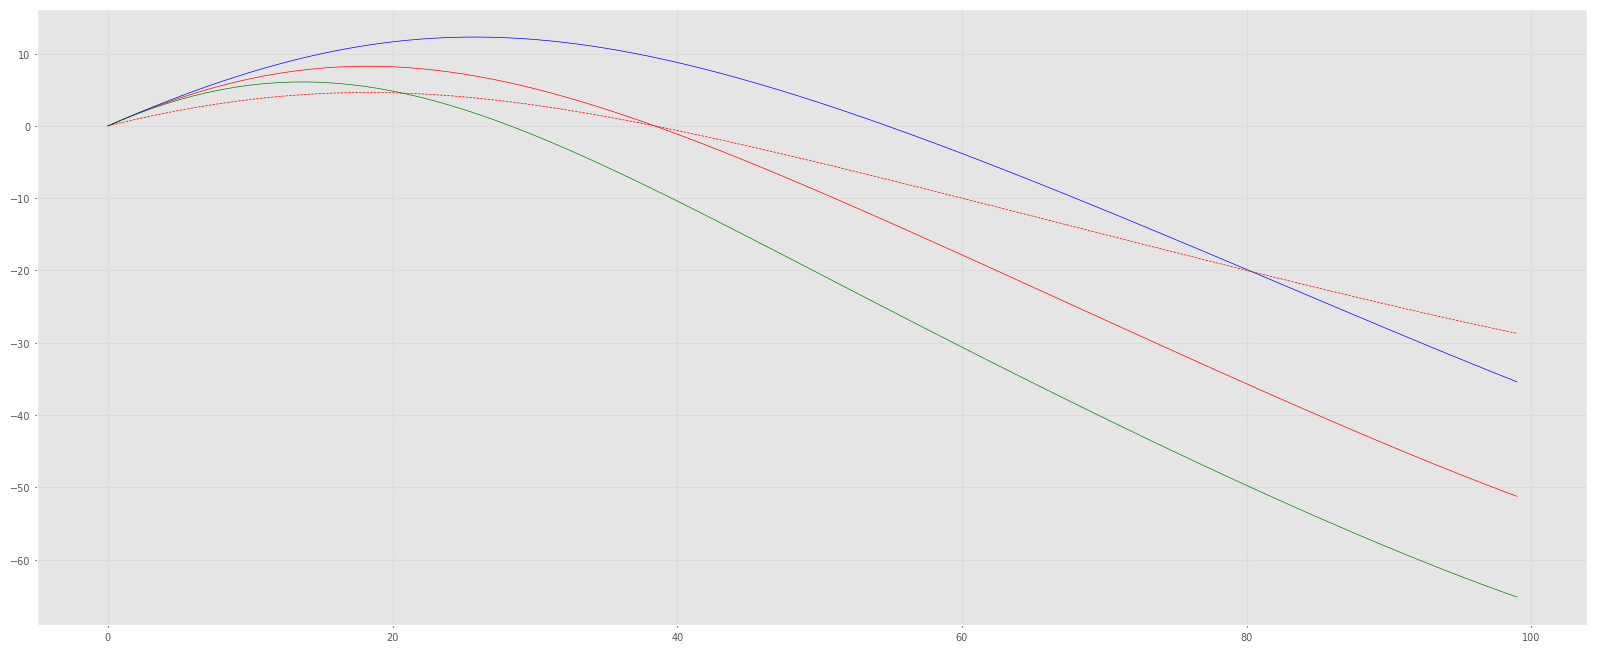

In [12]:
m1 = np.array(all_angles)[:, 0]
m2 = np.array(all_angles)[:, 1]
m3 = np.array(all_angles)[:, 2]

v1 = []
v2 = []
v3 = []
for i in range(len(m1) - 1):
    v1.append((m1[i+1] - m1[i])/0.01)
    v2.append((m2[i+1] - m2[i])/0.01)
    v3.append((m3[i+1] - m3[i])/0.01)

plt.figure(figsize  =  (20, 8))
plt.plot(m1[:100], c = 'red')
plt.plot(m2[:100], c = 'blue')
plt.plot(m3[:100], c = 'green')

m1_steps = m1[:100]*0.56
plt.plot(m1_steps, c = 'red', linestyle = '--')


plt.show()

In [17]:
def map_angle_to_analog(angle_degrees):
    # Normalize angle to [0, 360] range
    normalized_angle = (angle_degrees + 360) % 360
    # Map to analog input range (0 to 1023)
    analog_value = int((normalized_angle/360)*1023)
    return analog_value

In [20]:
map_angle_to_analog(45)

127

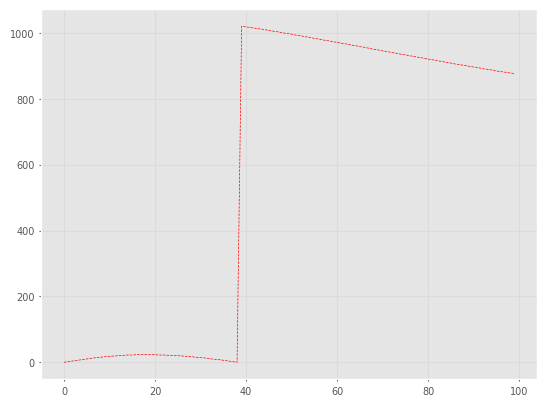

In [19]:
m1_steps_analog = [map_angle_to_analog(angle) for angle in m1[:100]]
plt.plot(m1_steps_analog, c = 'red', linestyle = '--')

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time, random, serial
from essentials import *

CONVEYOR_SPEED = 50  
MOTOR_SPEED = 100  
ANGLE_PER_STEP = 1.8

r = 171.5
h = 200
s = 50
k = 435
Zt = 0
robot = DeltaRobot(r, h, s, k, Zt)
        
    
object_points = np.array([[0, 100, -500], [100, -100, -500], [200, 0, -500]])
green_box_location = np.array([100, -230, -500])

from essentials import *
        

test_path = PNPTestPath(robot, object_points, green_box_location)
commands, full_path = test_path.plan_path()

In [5]:
commands = np.array(commands)
m1_commands = commands[:, 0]
m2_commands = commands[:, 1]
m3_commands = commands[:, 2]

In [10]:
# Absolute steps
steps = m1_commands/(360/1600)

In [11]:
np.round(steps)

array([         -0,           4,           7,          11,          14,          17,          20,          22,          25,          27,          29,          31,          32,          34,          35,          36,          36,          37,          37,          37,          36,          36,          35,          34,
                33,          32,          30,          29,          27,          25,          23,          21,          18,          16,          13,          10,           7,           4,           1,          -2,          -5,          -8,         -12,         -15,         -19,         -22,         -26,         -29,
               -33,         -37,         -41,         -44,         -48,         -52,         -56,         -60,         -64,         -67,         -71,         -75,         -79,         -83,         -87,         -91,         -95,         -99,        -103,        -107,        -111,        -115,        -119,        -123,
              -127,        -131,        -13

In [12]:
len(steps)

703

In [3]:
from essentials import *

In [6]:
r = 171.5
h = 200
s = 50
k = 435
Zt = 0
robot = DeltaRobot(r, h, s, k, Zt)

[J1, J2, J3] = robot.calculate_inv_kinematics(0, 0, -333)

In [7]:
J1, J2, J3

(-10.4749, -10.4749, -10.4749)